# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
# data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

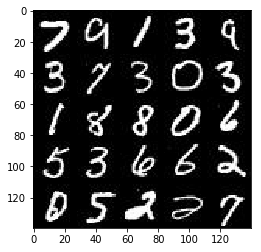

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

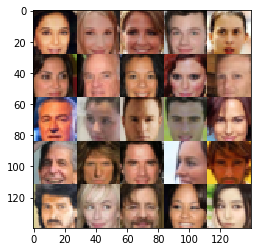

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    real_imgs = tf.placeholder(dtype=tf.float32, 
                               shape=[None, image_height, image_width, image_channels], 
                               name='real_imgs')
    z_input = tf.placeholder(dtype=tf.float32, shape=[None, z_dim])
    l_rate = tf.placeholder(dtype=tf.float32, shape=(), name='l_rate')
    return real_imgs, z_input, l_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, is_train=True):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, kernel_size=5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(x2, 256, kernel_size=3, strides=1, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 1x1x256

        # Flatten it
        flat = tf.reshape(x3, (-1, 256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        return logits, out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, reuse = False, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    with tf.variable_scope('generator', reuse=reuse):
        
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x256 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, kernel_size=2, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x128 now

        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, kernel_size=2, strides=2, padding='same')
        # 28x28xout_channel_dim now
        
        out = tf.tanh(logits)
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

AssertionError: tf.variable_scope called with wrong arguments in Generator Inference(reuse=True)

### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    g_model = generator(input_z, out_channel_dim, reuse = False, is_train=True)
    
    d_model_real, d_logits_real = discriminator(input_real, reuse=False, is_train=True)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, is_train=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(5*learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, True, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    print_every=10
    show_every=20
    
    image_height, image_width = data_shape[1], data_shape[2]
    if data_image_mode == 'RGB':
        image_channels = 3
    elif data_image_mode == 'L':
        image_channels = 1
    else:
        raise Exception('Incorrect "data_image_mode"')
            
    real_imgs, z_input, l_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(real_imgs, z_input, image_channels)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, l_rate, beta1)
    
    samples, losses = [], []
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={real_imgs: batch_images, z_input: batch_z, l_rate:learning_rate})
                _ = sess.run(g_train_opt, feed_dict={real_imgs: batch_images, z_input: batch_z, l_rate:learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({real_imgs: batch_images, z_input: batch_z})
                    train_loss_g = g_loss.eval({z_input: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, n_images=25, input_z=z_input, 
                                          out_channel_dim=image_channels, 
                                          image_mode=data_image_mode)
        
        show_generator_output(sess, n_images=25, input_z=z_input, out_channel_dim=image_channels, image_mode=data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.4563... Generator Loss: 0.4484
Epoch 1/2... Discriminator Loss: 1.4528... Generator Loss: 0.4558


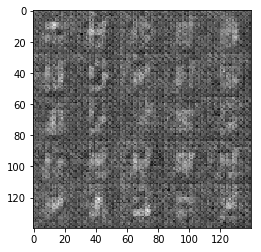

Epoch 1/2... Discriminator Loss: 1.4442... Generator Loss: 0.4874
Epoch 1/2... Discriminator Loss: 1.4333... Generator Loss: 0.5020


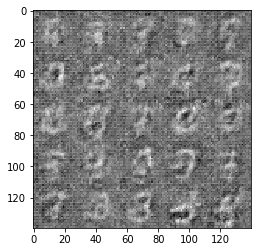

Epoch 1/2... Discriminator Loss: 1.4235... Generator Loss: 0.5174
Epoch 1/2... Discriminator Loss: 1.4146... Generator Loss: 0.5344


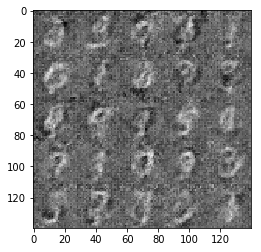

Epoch 1/2... Discriminator Loss: 1.4040... Generator Loss: 0.5477
Epoch 1/2... Discriminator Loss: 1.3590... Generator Loss: 0.5543


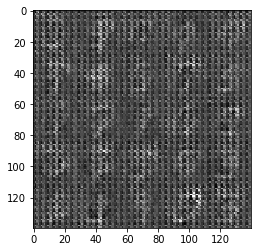

Epoch 1/2... Discriminator Loss: 1.3910... Generator Loss: 0.5571
Epoch 1/2... Discriminator Loss: 1.3747... Generator Loss: 0.5923


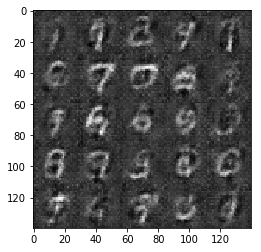

Epoch 1/2... Discriminator Loss: 1.3614... Generator Loss: 0.6043
Epoch 2/2... Discriminator Loss: 1.3651... Generator Loss: 0.6120


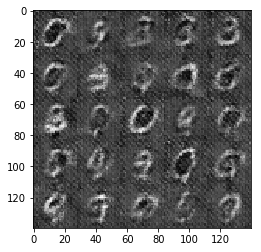

Epoch 2/2... Discriminator Loss: 1.3441... Generator Loss: 0.5624
Epoch 2/2... Discriminator Loss: 1.2743... Generator Loss: 0.6009


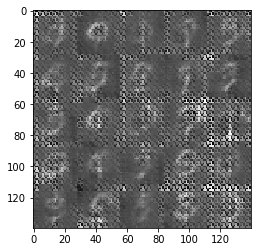

Epoch 2/2... Discriminator Loss: 1.3317... Generator Loss: 0.5753
Epoch 2/2... Discriminator Loss: 1.3541... Generator Loss: 0.5609


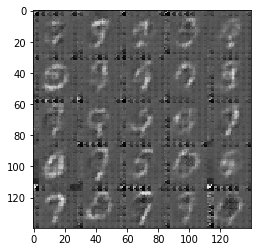

Epoch 2/2... Discriminator Loss: 1.3828... Generator Loss: 0.5509
Epoch 2/2... Discriminator Loss: 1.3394... Generator Loss: 0.6134


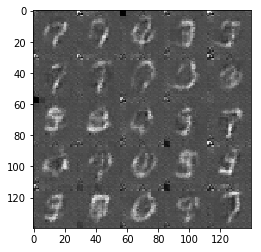

Epoch 2/2... Discriminator Loss: 1.3530... Generator Loss: 0.6113
Epoch 2/2... Discriminator Loss: 1.3633... Generator Loss: 0.6117


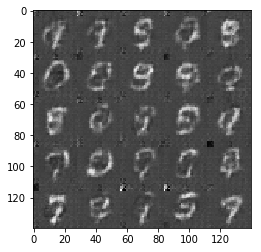

Epoch 2/2... Discriminator Loss: 1.3424... Generator Loss: 0.6009
Epoch 2/2... Discriminator Loss: 1.3551... Generator Loss: 0.6094


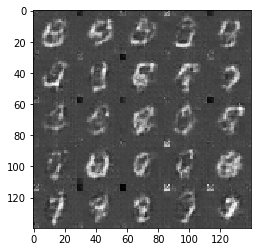

Epoch 2/2... Discriminator Loss: 1.2873... Generator Loss: 0.6307


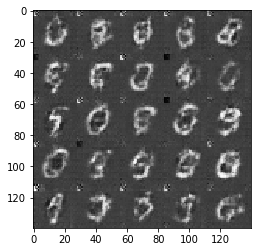

In [14]:
batch_size = 512
z_dim = 100
learning_rate = 0.0002
beta1 = 0.2

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, 
          beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/2... Discriminator Loss: 1.4226... Generator Loss: 0.4580
Epoch 1/2... Discriminator Loss: 1.4667... Generator Loss: 0.4429


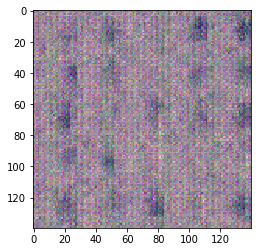

Epoch 1/2... Discriminator Loss: 1.4609... Generator Loss: 0.4696
Epoch 1/2... Discriminator Loss: 1.4439... Generator Loss: 0.4928


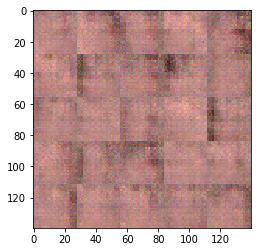

Epoch 1/2... Discriminator Loss: 1.4290... Generator Loss: 0.5053
Epoch 1/2... Discriminator Loss: 1.4134... Generator Loss: 0.5188


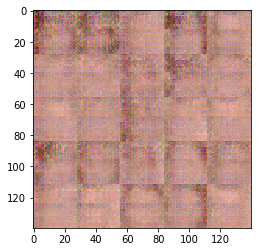

Epoch 1/2... Discriminator Loss: 1.4047... Generator Loss: 0.5293
Epoch 1/2... Discriminator Loss: 1.3821... Generator Loss: 0.5436


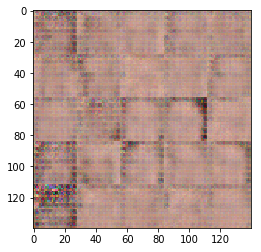

Epoch 1/2... Discriminator Loss: 1.3359... Generator Loss: 0.5564
Epoch 1/2... Discriminator Loss: 1.3636... Generator Loss: 0.5612


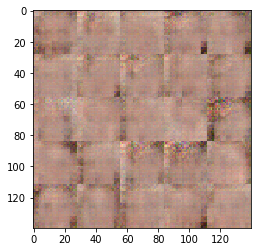

Epoch 1/2... Discriminator Loss: 1.3574... Generator Loss: 0.5687
Epoch 1/2... Discriminator Loss: 1.3028... Generator Loss: 0.5716


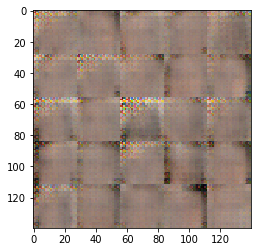

Epoch 1/2... Discriminator Loss: 1.2974... Generator Loss: 0.5723
Epoch 1/2... Discriminator Loss: 1.2763... Generator Loss: 0.5870


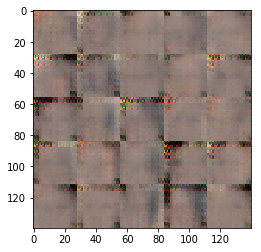

Epoch 1/2... Discriminator Loss: 1.2616... Generator Loss: 0.6120
Epoch 1/2... Discriminator Loss: 1.4057... Generator Loss: 0.5288


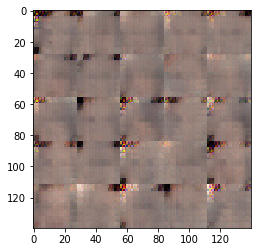

Epoch 1/2... Discriminator Loss: 1.2845... Generator Loss: 0.5811
Epoch 1/2... Discriminator Loss: 1.3277... Generator Loss: 0.5509


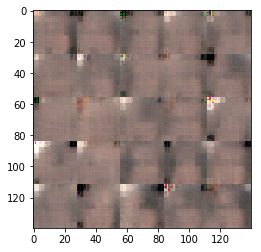

Epoch 1/2... Discriminator Loss: 1.3256... Generator Loss: 0.6188
Epoch 1/2... Discriminator Loss: 1.3695... Generator Loss: 0.5422


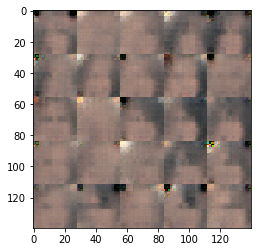

Epoch 1/2... Discriminator Loss: 1.2916... Generator Loss: 0.6144
Epoch 1/2... Discriminator Loss: 1.2699... Generator Loss: 0.6214


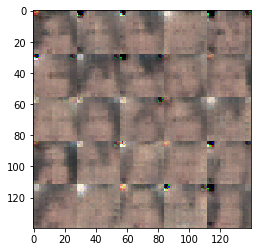

Epoch 1/2... Discriminator Loss: 1.2731... Generator Loss: 0.6404
Epoch 1/2... Discriminator Loss: 1.3063... Generator Loss: 0.6301


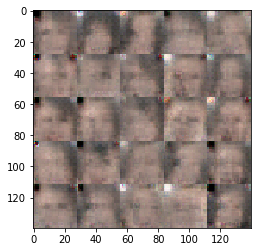

Epoch 1/2... Discriminator Loss: 1.3093... Generator Loss: 0.5819
Epoch 1/2... Discriminator Loss: 1.2759... Generator Loss: 0.6271


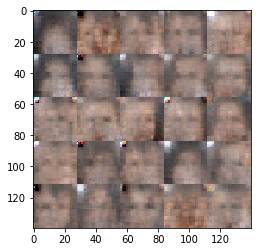

Epoch 1/2... Discriminator Loss: 1.2735... Generator Loss: 0.6092
Epoch 1/2... Discriminator Loss: 1.2708... Generator Loss: 0.6242


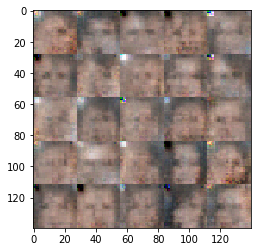

Epoch 1/2... Discriminator Loss: 1.3030... Generator Loss: 0.6152
Epoch 1/2... Discriminator Loss: 1.2481... Generator Loss: 0.6403


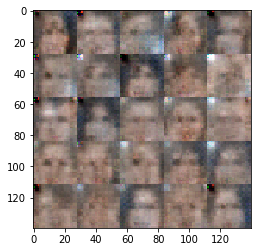

Epoch 1/2... Discriminator Loss: 1.2761... Generator Loss: 0.6172
Epoch 1/2... Discriminator Loss: 1.2717... Generator Loss: 0.6458


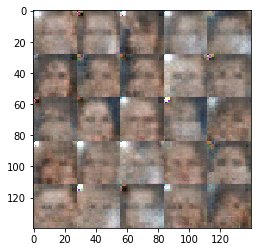

Epoch 1/2... Discriminator Loss: 1.3149... Generator Loss: 0.5978
Epoch 1/2... Discriminator Loss: 1.2788... Generator Loss: 0.6306


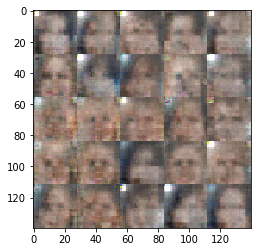

Epoch 1/2... Discriminator Loss: 1.3514... Generator Loss: 0.5489
Epoch 1/2... Discriminator Loss: 1.2527... Generator Loss: 0.6326


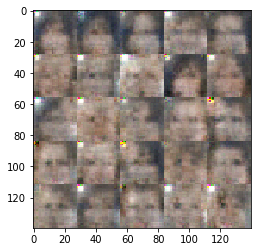

Epoch 1/2... Discriminator Loss: 1.2952... Generator Loss: 0.6065
Epoch 1/2... Discriminator Loss: 1.2678... Generator Loss: 0.6445


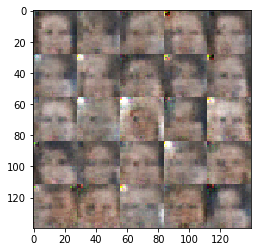

Epoch 1/2... Discriminator Loss: 1.2469... Generator Loss: 0.6257
Epoch 2/2... Discriminator Loss: 1.2988... Generator Loss: 0.5774


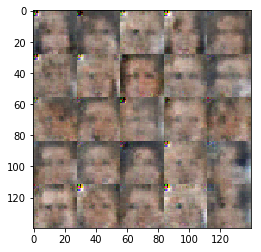

Epoch 2/2... Discriminator Loss: 1.2317... Generator Loss: 0.6306
Epoch 2/2... Discriminator Loss: 1.2579... Generator Loss: 0.6329


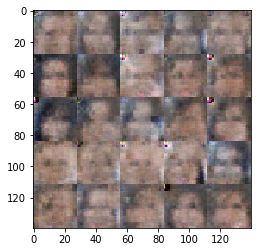

Epoch 2/2... Discriminator Loss: 1.2186... Generator Loss: 0.6511
Epoch 2/2... Discriminator Loss: 1.2959... Generator Loss: 0.5783


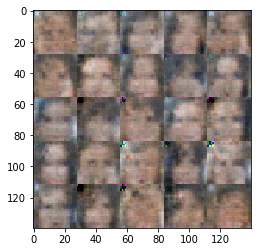

Epoch 2/2... Discriminator Loss: 1.1669... Generator Loss: 0.6692
Epoch 2/2... Discriminator Loss: 1.2196... Generator Loss: 0.6481


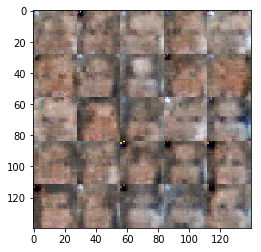

Epoch 2/2... Discriminator Loss: 1.2516... Generator Loss: 0.6079
Epoch 2/2... Discriminator Loss: 1.2117... Generator Loss: 0.6344


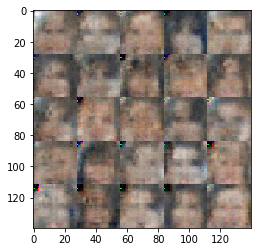

Epoch 2/2... Discriminator Loss: 1.2355... Generator Loss: 0.6351
Epoch 2/2... Discriminator Loss: 1.2091... Generator Loss: 0.6474


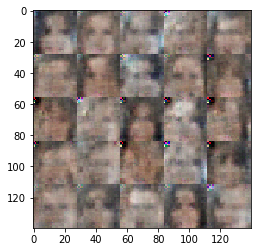

Epoch 2/2... Discriminator Loss: 1.2104... Generator Loss: 0.6422
Epoch 2/2... Discriminator Loss: 1.2872... Generator Loss: 0.5923


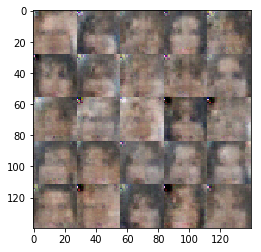

Epoch 2/2... Discriminator Loss: 1.1631... Generator Loss: 0.6612
Epoch 2/2... Discriminator Loss: 1.2920... Generator Loss: 0.6435


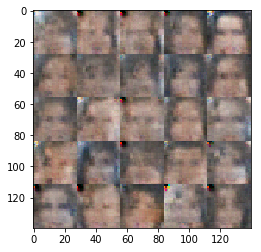

Epoch 2/2... Discriminator Loss: 1.1986... Generator Loss: 0.6363
Epoch 2/2... Discriminator Loss: 1.2173... Generator Loss: 0.6589


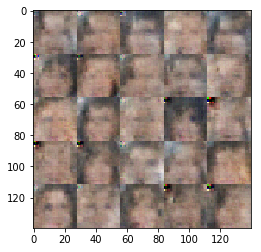

Epoch 2/2... Discriminator Loss: 1.2160... Generator Loss: 0.6495
Epoch 2/2... Discriminator Loss: 1.2172... Generator Loss: 0.6226


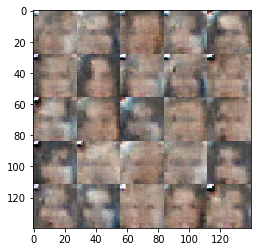

Epoch 2/2... Discriminator Loss: 1.2007... Generator Loss: 0.6461
Epoch 2/2... Discriminator Loss: 1.1557... Generator Loss: 0.6591


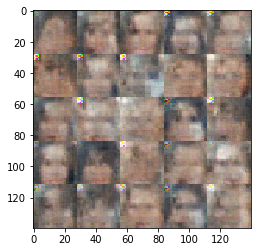

Epoch 2/2... Discriminator Loss: 1.2368... Generator Loss: 0.6083
Epoch 2/2... Discriminator Loss: 1.1905... Generator Loss: 0.6346


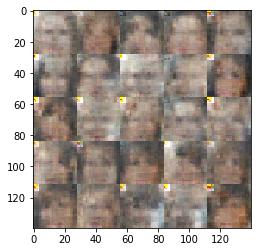

Epoch 2/2... Discriminator Loss: 1.3256... Generator Loss: 0.6542
Epoch 2/2... Discriminator Loss: 1.1515... Generator Loss: 0.6651


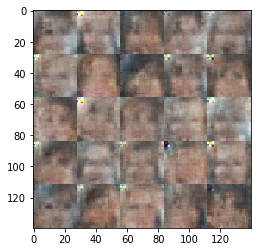

Epoch 2/2... Discriminator Loss: 1.1561... Generator Loss: 0.6701
Epoch 2/2... Discriminator Loss: 1.1828... Generator Loss: 0.6345


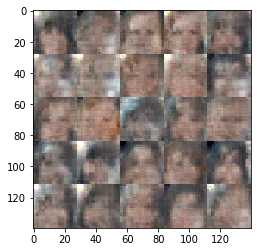

Epoch 2/2... Discriminator Loss: 1.1522... Generator Loss: 0.6557
Epoch 2/2... Discriminator Loss: 1.2019... Generator Loss: 0.6553


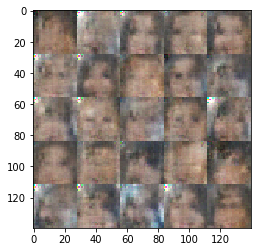

Epoch 2/2... Discriminator Loss: 1.2091... Generator Loss: 0.6446
Epoch 2/2... Discriminator Loss: 1.1346... Generator Loss: 0.6784


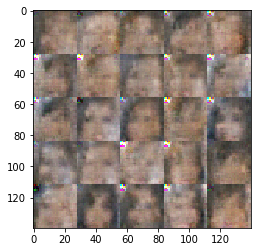

Epoch 2/2... Discriminator Loss: 1.1857... Generator Loss: 0.6370
Epoch 2/2... Discriminator Loss: 1.1829... Generator Loss: 0.6439


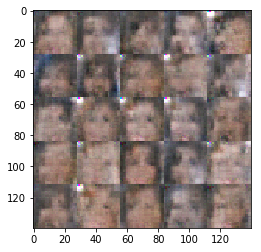

Epoch 2/2... Discriminator Loss: 1.1383... Generator Loss: 0.6654
Epoch 2/2... Discriminator Loss: 1.1875... Generator Loss: 0.6347


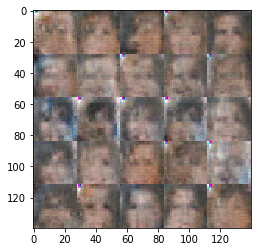

Epoch 2/2... Discriminator Loss: 1.1666... Generator Loss: 0.6462
Epoch 2/2... Discriminator Loss: 1.1112... Generator Loss: 0.6802


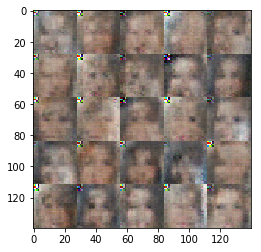

Epoch 2/2... Discriminator Loss: 1.1200... Generator Loss: 0.6648
Epoch 2/2... Discriminator Loss: 1.1485... Generator Loss: 0.6511


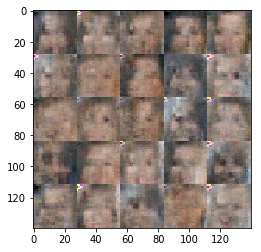

In [ ]:
batch_size = 512
z_dim = 100
learning_rate = 0.0002
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.